In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
import re
import sys
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder

In [2]:
def extract_int(x):
    int_list = re.findall(r'\d+', x)
    return int("".join(int_list))


In [3]:
df = pd.read_csv('loan-data\Anonymize_Loan_Default_data.csv', encoding= 'ISO-8859-1')

In [4]:
df.describe(include = 'all')

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,...,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,repay_fail
count,38480.000000,3.848000e+04,3.848000e+04,38479.000000,38479.000000,38479.000000,38480,38480.00000,38479.000000,37487,...,38479.000000,38479.000000,38479.000000,38479.000000,38479.000000,38409,38479.000000,3383,38477,38480.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,11,...,NaN,NaN,NaN,NaN,NaN,105,NaN,103,110,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,36 months,NaN,NaN,10+ years,...,NaN,NaN,NaN,NaN,NaN,Jun-16,NaN,Jul-16,Jun-16,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,28593,NaN,NaN,8465,...,NaN,NaN,NaN,NaN,NaN,1022,NaN,909,11342,NaN
mean,19240.500000,6.649979e+05,8.261899e+05,11094.727644,10831.856337,10150.141518,NaN,12.16430,323.163255,NaN,...,22.108501,11980.696892,11274.519569,9646.412705,2232.768235,NaN,2614.441757,NaN,NaN,0.151481
std,11108.363516,2.192322e+05,2.793531e+05,7405.416042,7146.853682,7128.026828,NaN,3.73744,209.089097,NaN,...,11.588602,9006.505205,8946.229941,7051.828302,2570.177312,NaN,4391.969583,NaN,NaN,0.358522
min,1.000000,1.000000e+00,1.000000e+00,0.000000,0.000000,0.000000,NaN,0.00000,0.000000,NaN,...,1.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000
25%,9620.750000,4.983645e+05,6.384620e+05,5200.000000,5100.000000,4950.000000,NaN,9.62000,165.740000,NaN,...,13.000000,5463.099238,4811.735000,4400.000000,657.700000,NaN,212.010000,NaN,NaN,0.000000
50%,19240.500000,6.443195e+05,8.242545e+05,9750.000000,9600.000000,8495.792749,NaN,11.99000,277.980000,NaN,...,20.000000,9673.221341,8953.240000,8000.000000,1335.090000,NaN,526.000000,NaN,NaN,0.000000
75%,28860.250000,8.265608e+05,1.034706e+06,15000.000000,15000.000000,14000.000000,NaN,14.72000,429.350000,NaN,...,29.000000,16402.394995,15486.925000,13315.100000,2795.020000,NaN,3169.815000,NaN,NaN,0.000000


#### Going to want to drop the items that will clearly have no correlation or will be far too difficult to evaluate effectively. (e.g. zip codes are a discrete variable with far too many values to be an effective predictor)

In [5]:
to_drop = ['Unnamed: 0', 'id', 'member_id', 'zip_code', 'verification_status', 'last_credit_pull_d','issue_d','loan_status', 'last_pymnt_d', 'next_pymnt_d', 'addr_state', 'earliest_cr_line']

#Also want to determine if any of the dates have information that could be used to determine default

null_count = df.isnull().sum(axis = 0)
print(null_count.sort_values(ascending=False)[0:5])
#Although null values for months since last delinquency likely imply the loanee has never been delinquent, it is a quite dangerous assumption to make.
#Simply assuming all 24363 values 
to_drop.extend(['mths_since_last_delinq','next_pymnt_d'])



bins = [0,3,9,10]
labels = ['0 - 2 years', '3 - 9 years', '10+ years']
#Have to drop na before performing this operation
df.dropna(subset=['emp_length'], inplace=True)
df['emp_length']  = df['emp_length'].apply(extract_int)
print(df['emp_length'])
df['emp_length'] = pd.cut(df['emp_length'], bins=bins, labels=labels)
df['emp_length'].value_counts()
le = LabelEncoder()
le.fit(labels)
df['emp_length'] = le.fit_transform(df['emp_length'])

next_pymnt_d              35097
mths_since_last_delinq    24363
emp_length                  993
last_pymnt_d                 71
revol_util                   59
dtype: int64
0         1
1         4
2         4
3        10
4        10
         ..
38475     3
38476     9
38477    10
38478     1
38479     7
Name: emp_length, Length: 37487, dtype: int64


In [6]:
df = df.dropna()

#Also going to break up some salary info
bins = [0,40000,60000,80000,sys.maxsize]
labels = ['0 - 40k', '40k - 60k', '60k - 80k', '80k+']

df['annual_inc'] = pd.cut(df['annual_inc'], bins=bins, labels=labels)
le = LabelEncoder()
le.fit(labels)
df['annual_inc'] = le.fit_transform(df['annual_inc'])

In [7]:
df = df.drop(to_drop, axis=1)

In [8]:
df['revol_util'] = df['revol_util'].str.rstrip('%').astype(float)

le = LabelEncoder()
le.fit(["36 months", "60 months"])
df['term'] = le.fit_transform(df['term'])

le = LabelEncoder()
le.fit(["MORTGAGE", "RENT", "OWN"])
df['home_ownership'] = le.fit_transform(df['home_ownership'])
                                           
le = LabelEncoder()
le.fit(['other', 'debt_consolidation', 'major_purchase', 'educational', 'small_business', 'car', 'wedding', 'medical', 'moving', 'house', 'vacation', 'wedding', 'renewable_energy'])
df['purpose'] = le.fit_transform(df['purpose'])



In [9]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='repay_fail'), df['repay_fail'],test_size=0.2)

print(X_train.columns)

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'home_ownership', 'annual_inc', 'purpose',
       'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec',
       'revol_bal', 'revol_util', 'total_acc', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'last_pymnt_amnt'],
      dtype='object')


In [12]:
estimator = LogisticRegression(solver='liblinear')
selector = RFE(estimator, n_features_to_select=6, step=1)
selector.fit(X_train,y_train)

       loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
29822     6000.0       6000.0      5950.000000     0     13.61       203.94   
5         3600.0       3600.0      3600.000000     0     10.25       116.59   
3110      8000.0       8000.0      8000.000000     0     14.83       276.66   
32763     3600.0       3600.0      3594.742470     0     14.61       124.12   
9924     14500.0      14500.0      4113.913998     0     16.63       514.32   

       emp_length  home_ownership  annual_inc  purpose  ...  open_acc  \
29822           2               3           0        4  ...       9.0   
5               1               0           3        9  ...       8.0   
3110            2               0           2        4  ...       6.0   
32763           0               4           0        6  ...       9.0   
9924            1               0           3        2  ...      12.0   

       pub_rec  revol_bal  revol_util  total_acc  total_pymnt  \
29822      0.0      1

RFE(estimator=LogisticRegression(solver='liblinear'), n_features_to_select=6)

In [14]:
print(selector.support_)
print(selector.ranking_)
X_train.columns[selector.support_]

[False False False False  True  True False False False  True False False
 False False False False False False  True False  True  True False]
[16  8 11 10  1  1 15  4  6  1  2 14  5  3  9 17 13  7  1 12  1  1 18]


Index(['int_rate', 'installment', 'purpose', 'total_pymnt', 'total_rec_prncp',
       'total_rec_int'],
      dtype='object')

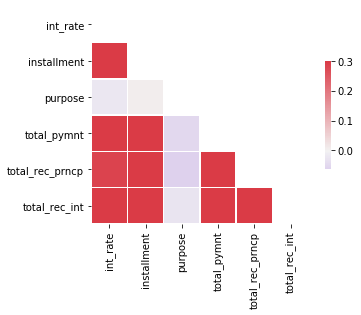

In [24]:
corr = X_train[X_train.columns[selector.support_]].corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(1000, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})  